In [1]:
import numpy as np
import pylab
import networkx as nx

from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
import pickle

import matplotlib.pyplot as plt

import random
random.seed(1234)

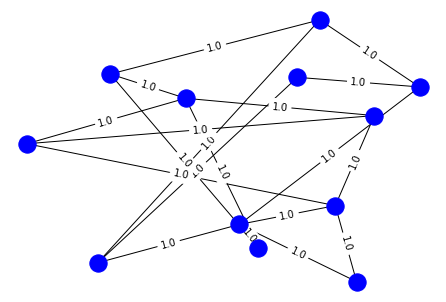

In [11]:
from MaxCut import MaxCut
max_cut = MaxCut(n_nodes=12)
max_cut.random_graph(0.85)
max_cut.plot_graph()

with open('max_cut_12.pkl', 'wb') as f:
    pickle.dump(max_cut, f)


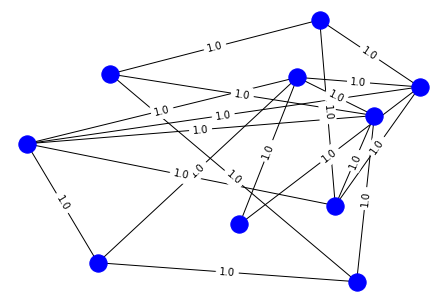

In [2]:
from MaxCut import MaxCut
with open('max_cut_10.pkl', 'rb') as file:
    max_cut = pickle.load(file)
max_cut.plot_graph()

In [3]:
qubit_op, _ = max_cut.get_operator()

In [4]:
optimizers = [COBYLA(maxiter=100), L_BFGS_B(maxiter=100), SLSQP(maxiter=100)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    # algorithm_globals.random_seed = 50
    # ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = QAOA(optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')), reps=2)
    result = vqe.compute_minimum_eigenvalue(operator=qubit_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


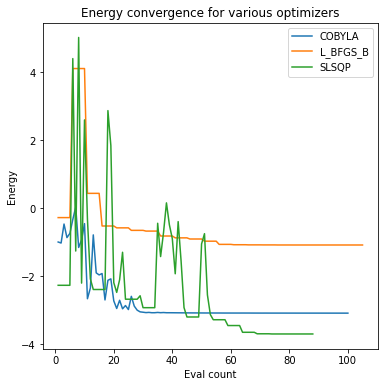

In [8]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');
plt.show()

In [9]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -13.00000


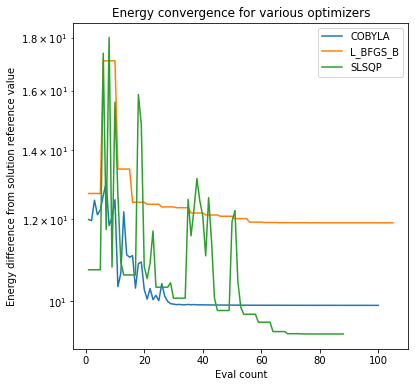

In [10]:
pylab.rcParams['figure.figsize'] = (6, 6)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');
plt.show()

In [10]:
from scipy.optimize import minimize
import pickle
from QAOA import QAOA
from qiskit import Aer
import random
import numpy as np

def random_init_parameters(layers):
    return np.array([random.uniform(0, np.pi) for i in range(layers*2)])

global iters
iters = []


random.seed(1234)

n_nodes = 10
p = 2
n_shots = 100
max_iter = 200

with open('max_cut_10.pkl', 'rb') as file:
    max_cut = pickle.load(file)

qaoa = QAOA(max_cut=max_cut, p=p, backend=Aer.get_backend('qasm_simulator'))

def callback(xk):
    global iters
    exp = check_result([i for i in xk])
    iters.append(exp)

obj = qaoa.compute_minimum_eigenvalue(n_shots=n_shots)
init_point = random_init_parameters(p)
res_sample = minimize(obj, init_point, method='L-BFGS-B', callback=callback, options={'maxiter': max_iter, 'disp': True})
print()

[] -8.55
[-8.55] -8.18
[-8.55, -8.18] -8.22


In [11]:
res_sample

      fun: -8.49
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 20000000.12154953,  28000000.17016912, -26999999.99547655,
        28000000.17016912])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 115
      nit: 3
     njev: 23
   status: 0
  success: True
        x: array([3.03620336, 1.38460295, 0.02353491, 2.86191416])

In [12]:
iters

[-8.55, -8.18, -8.22]

In [9]:
from qiskit import execute
from QAOA import compute_expectation_value

def check_result(x):
    qaoa.build_circuit()
    qaoa.ansatz = qaoa.ansatz.assign_parameters({qaoa.ansatz.parameters[i]: x[i] for i in range(p*2)})
    qaoa.ansatz.measure_all()
    
    job = execute(qaoa.ansatz, Aer.get_backend('qasm_simulator'), shots=n_shots)
    result = job.result().get_counts()
    exp_value = compute_expectation_value(result, qaoa.max_cut)
    return exp_value

In [20]:
random.seed(1234)
check_result(res_sample['x'])

-8.54
